## Predicting Gym Class Attendance

### 1. Data Preparation, Cleaning and Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = "https://raw.githubusercontent.com/bankymondial/Predicting-Gym-Class-Attendance/refs/heads/main/fitness_class_2212.csv"

In [3]:
df = pd.read_csv(data)

In [4]:
df.head()

,booking_id,months_as_member,weight,days_before,day_of_week,time,category,attended
0,1,17,79.56,8,Wed,PM,Strength,0
1,2,10,79.01,2,Mon,AM,HIIT,0
2,3,16,74.53,14,Sun,AM,Strength,0
3,4,5,86.12,10,Fri,AM,Cycling,0
4,5,15,69.29,8,Thu,AM,HIIT,0


In [5]:
df.dtypes

booking_id            int64
months_as_member      int64
weight              float64
days_before          object
day_of_week          object
time                 object
category             object
attended              int64
dtype: object

In [6]:
df.isna().sum()

booking_id           0
months_as_member     0
weight              20
days_before          0
day_of_week          0
time                 0
category             0
attended             0
dtype: int64

#### To replace the missing values in `weight`, it's necessary to explore the distribution of the feature.

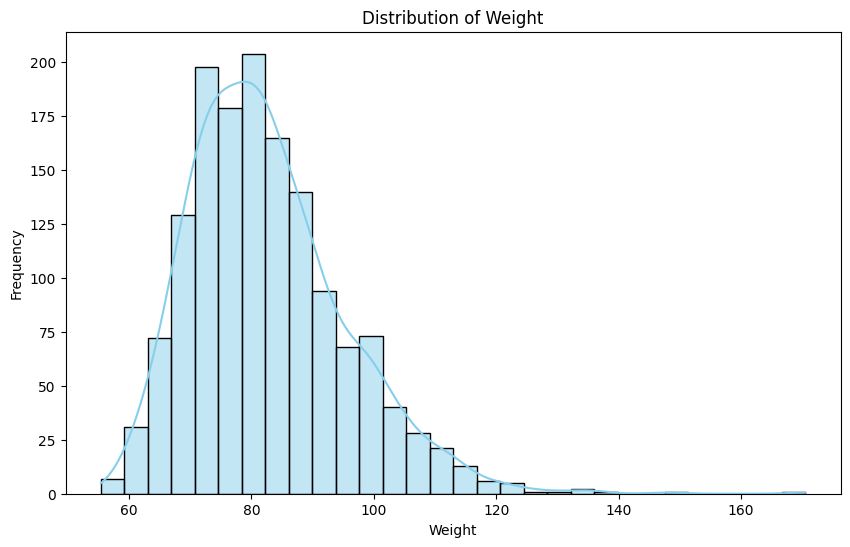

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(df['weight'], kde=True, bins=30, color='skyblue')  # KDE (Kernel Density Estimation) adds a smooth line
plt.title('Distribution of Weight')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.show()

#### Since the distribution is right-skewed, it's better to impute the missing values with the `median` since it is not affected by outliers or the long tail of the distribution.

In [8]:
df.weight = df.weight.fillna(df.weight.median())

In [9]:
df.isna().sum()

booking_id          0
months_as_member    0
weight              0
days_before         0
day_of_week         0
time                0
category            0
attended            0
dtype: int64

#### Next, there is a need to delete `booking_id`, convert `days_before` to integers.

In [10]:
df.drop('booking_id', axis=1, inplace=True)

In [11]:
print(df.days_before.unique())
print("---------------------")
print(df.days_before.dtype)

['8' '2' '14' '10' '6' '4' '9' '12' '5' '3' '7' '13' '12 days' '20' '1'
 '15' '6 days' '11' '13 days' '3 days' '16' '1 days' '7 days' '8 days'
 '10 days' '14 days' '17' '5 days' '2 days' '4 days' '29']
---------------------
object


In [12]:
df.days_before = df.days_before.str.replace(r' days$', '', regex=True) # Remove ' days'

In [13]:
df.days_before = pd.to_numeric(df.days_before, errors='coerce').astype(int) # Convert the cleaned values to integers

In [14]:
df.dtypes

months_as_member      int64
weight              float64
days_before           int64
day_of_week          object
time                 object
category             object
attended              int64
dtype: object

#### Then, we need to ensure that all columns have unique values.

In [15]:
unique_values = df.apply(lambda x: x.unique())
print("\nUnique values in each column:")
print(unique_values)


Unique values in each column:
months_as_member    [17, 10, 16, 5, 15, 7, 11, 9, 23, 13, 8, 22, 6...
weight              [79.56, 79.01, 74.53, 86.12, 69.29, 93.33, 88....
days_before         [8, 2, 14, 10, 6, 4, 9, 12, 5, 3, 7, 13, 20, 1...
day_of_week         [Wed, Mon, Sun, Fri, Thu, Wednesday, Fri., Tue...
time                                                         [PM, AM]
category                     [Strength, HIIT, Cycling, Yoga, -, Aqua]
attended                                                       [0, 1]
dtype: object


In [16]:
df.day_of_week = df.day_of_week.replace({'Wednesday': 'Wed', 'Monday': 'Mon'})  # Replace 'Wednesday' with 'Wed'
df.day_of_week = df.day_of_week.str.replace(r'Fri\.$', 'Fri', regex=True)  # Use raw string to remove period from 'Fri.'

df.category = df.category.replace('-', 'Unknown')  # Replace with "Unknown" instead of NaN to prevent information loss

In [17]:
df.head()

,months_as_member,weight,days_before,day_of_week,time,category,attended
0,17,79.56,8,Wed,PM,Strength,0
1,10,79.01,2,Mon,AM,HIIT,0
2,16,74.53,14,Sun,AM,Strength,0
3,5,86.12,10,Fri,AM,Cycling,0
4,15,69.29,8,Thu,AM,HIIT,0


### 2. Splitting the dataset
 - Performing a 60%/20%/20% splits for training/validation/test datasets respectively

In [18]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [19]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [20]:
y_train = df_train['attended'].values
y_val = df_val['attended'].values
y_test = df_test['attended'].values

In [21]:
del df_train['attended']
del df_val['attended']
del df_test['attended']

### 4. Feature importance: Mutual information and Correlation
- Mutual information tells us how much we can learn about one variable if we know the value of another. In this project, it's a way to measure the importance of categorical variables. - https://en.wikipedia.org/wiki/Mutual_information
- A correlation coefficient is a numerical measure of some type of linear correlation, meaning a statistical relationship between two variables. https://en.wikipedia.org/wiki/Correlation_coefficient. It's a way to measure the importance of numerical variables.

#### Mutual information

In [22]:
numerical = ['months_as_member', 'weight', 'days_before']
categorical = ['day_of_week', 'time', 'category']

In [23]:
from sklearn.metrics import mutual_info_score

In [24]:
def mutual_info_attended_score(series):
    return mutual_info_score(series, df_full_train.attended)

In [25]:
mi = df_full_train[categorical].apply(mutual_info_attended_score)
mi.sort_values(ascending=False)

day_of_week    0.002950
time           0.001832
category       0.001477
dtype: float64

#### The low values of mutual information score between the categorical variables and the target variable `attended` implies that the day of the week, time of day nor the fitness class category give little insight into whether a member attended the gym or not.

#### Correlation coefficient

In [26]:
df_full_train[numerical].corrwith(df_full_train.attended).abs()

months_as_member    0.495458
weight              0.285607
days_before         0.028191
dtype: float64

#### The positive values of correlation coefficient implies that the likelihood of attendance increases with increase in each of them but at varying levels.
- `months_as_member` has the highest value albeit moderate relationship with attendance.
- As a member's `weight` increases, the likelihood of attendance increases but the relationship is weak.
- The `days_before` has almost no relationship with whether a person attends the gym.

#### Further insights into relationships between the `categorical` and `numerical` variables 

In [27]:
overall_attendance_rate = df_full_train['attended'].mean()
print("Overall attendance rate:", overall_attendance_rate)

Overall attendance rate: 0.29583333333333334


In [28]:
df_full_train[(df_full_train.months_as_member >= 24) & (df_full_train.weight >= 80)].attended.mean()

np.float64(0.6666666666666666)

In [29]:
df_full_train[(df_full_train.months_as_member >= 24) & (df_full_train.weight < 80)].attended.mean()

np.float64(0.7763975155279503)

In [30]:
df_full_train[(df_full_train.months_as_member >= 24) & (df_full_train.time == 'am')].attended.mean()

nan

#### Implication
- Members who have been with the organization for 2 years or more and weigh less than 80 kg have a higher attendance rate (77.6%) than those who weigh 80 kg or more (66.6%), indicating that `weight` might be a factor influencing attendance, and the lighter group appears more likely to attend compared to the heavier group, at least for long-term members.
- The AM session group (time == 'AM') has an attendance rate comparable to the lighter weight group (weight < 80 kg), which suggests that AM sessions might be preferred by certain subgroups of long-term members (perhaps those who are lighter or simply have different preferences for class timing).
- There's also the possibility that weight and time of day interact, so individuals with specific weight groups might prefer certain times of the day.

#### Conclusion
While each of the variables may not have strong relationship with whether a member attends, on their own, there are interesting patterns among the variables.

### 5. Training the models, tuning their performance and selecting the best model

In [31]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [32]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [33]:
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]
attendance_decision = (y_pred >= 0.5)
(y_val == attendance_decision).mean()

np.float64(0.78)

#### 5a. Accuracy and dummy model
- Evaluating the model on different thresholds
- Checking the accuracy on dummy baselines

In [34]:
from sklearn.metrics import accuracy_score

In [35]:
accuracy_score(y_val, y_pred >= 0.5)

0.78

In [36]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.350
0.05 0.363
0.10 0.487
0.15 0.627
0.20 0.727
0.25 0.757
0.30 0.773
0.35 0.773
0.40 0.763
0.45 0.790
0.50 0.780
0.55 0.770
0.60 0.760
0.65 0.753
0.70 0.747
0.75 0.733
0.80 0.730
0.85 0.730
0.90 0.710
0.95 0.700
1.00 0.650


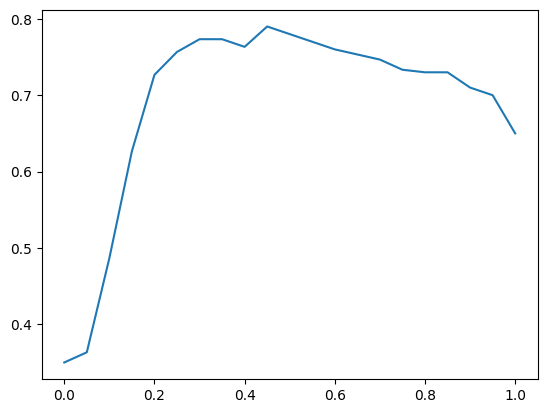

In [37]:
plt.plot(thresholds, scores)

In [38]:
from collections import Counter

In [39]:
Counter(y_pred >= 1.0)

Counter({np.False_: 300})

In [40]:
Counter(y_val)

Counter({np.int64(0): 195, np.int64(1): 105})

In [41]:
1 - y_val.mean()

np.float64(0.65)

#### A value of 0.65 implies that 65% of the data is negative (members that do not attend the class) while 35% of the data is positive (members that attend the class), signifying *class imbalance*. The model will do well at predicting whether a member does not attend the class but poorly at whether a member does attend the class, which is the problem we're trying to solve.

#### To estimate model performance due to class imbalance, there is a need to compute precision (and confusion matrix before that), recall, F1-score, ROC-AUC and cross-validation.

In [42]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [43]:
t= 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [44]:
tp = (predict_positive & actual_positive).sum() #tp is true positive: correctly predicted attendance instances
tn = (predict_negative & actual_negative).sum() #tn is true negative: correctly predicted no-attendance instance

In [45]:
tp, tn

(np.int64(48), np.int64(186))

In [46]:
fp = (predict_positive & actual_negative).sum() #fp is false positive: incorrectly predicted attendance instances
fn = (predict_negative & actual_positive).sum() #fn is false negative: incorrectly predicted no-attendance instance

In [47]:
fp, fn

(np.int64(9), np.int64(57))

In [48]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]]
)
confusion_matrix

array([[186,   9],
       [ 57,  48]])

In [49]:
(confusion_matrix / confusion_matrix.sum()).round(2) #confusion matric represented in proportion terms.

array([[0.62, 0.03],
       [0.19, 0.16]])

#### 5b. Precision and Recall

In [50]:
Accuracy = (tp + tn) / (tp + tn + fp + fn)
Accuracy

np.float64(0.78)

##### Precision is the fraction of positive predictions (members that are predicted to attend the class) are correct

In [51]:
p = tp / (tp + fp)
p

np.float64(0.8421052631578947)

##### Recall is the fraction of correctly identified positive predictions

In [52]:
r = tp / (tp + fn)
r

np.float64(0.45714285714285713)

##### A score of 0.457 implies that the model only correctly identifies 45.7% of gym class attendees, meaning that false negatives are relatively high.

#### 5c. F1 score
- a performance metric that combines precision and recall into a single score.

In [53]:
F1_score = (2 * p * r) / (p + r)
F1_score

np.float64(0.5925925925925926)

##### A score of 0.593 means that the model ios performing moderately and there is room for improvement.

#### 5d. ROC AUC

In [54]:
from sklearn.metrics import roc_auc_score

In [55]:
tpr = tp / (tp + fn)
tpr                             # same as recall

np.float64(0.45714285714285713)

In [56]:
fpr = fp / (fp + tn)
fpr

np.float64(0.046153846153846156)

In [57]:
roc_auc_score(y_val, y_pred)

np.float64(0.8364835164835165)

##### Given a score 0.836, the model is doing a good job of distinguishing between the positive and negative classes.

In [58]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

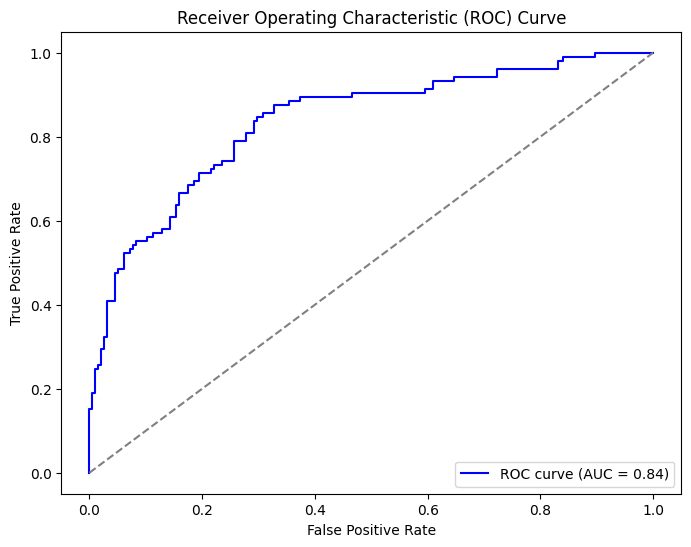

In [59]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#### 5e. Cross-Validation
- Evaluating the model on different subsets of data
- Getting the average prediction and the spread within predictions

In [60]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, solver='liblinear', random_state=1, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [61]:
dv, model = train(df_train, y_train, C=0.001)

In [62]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [63]:
y_pred = predict(df_val, dv, model)

In [64]:
from sklearn.model_selection import KFold

In [65]:
!pip install tqdm

In [66]:
from tqdm.auto import tqdm

In [67]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.attended.values
        y_val = df_val.attended.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.812 +- 0.023
C=0.01 0.813 +- 0.023
C=0.1 0.816 +- 0.021
C=0.5 0.818 +- 0.021
C=1 0.819 +- 0.021
C=5 0.819 +- 0.020
C=10 0.818 +- 0.020


##### Note: `C` is a regularization parameter commonly used in models like Logistic Regression and Support Vector Machines (SVMs). It controls the trade-off between achieving a low error on the training data and ensuring that the model remains generalizable (not overfitting).

In [68]:
scores

[np.float64(0.821404174573055),
 np.float64(0.8365625),
 np.float64(0.8307113543091655),
 np.float64(0.8230171364359958),
 np.float64(0.7799300511164918)]

In [69]:
dv, model = train(df_full_train, df_full_train.attended.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

np.float64(0.7852655912357405)

- Next steps: testing other algorithms like XGBoost and Feature Interaction Model to see if they offer better predictive power.